# Look at UMAP outliers identified on the co-occ UMAP in more detail

In [1]:
from campa.constants import campa_config
from campa_ana.constants import SOURCE_DIR
from pathlib import Path
from campa.data import MPPData
from campa.tl import Experiment
from campa.tl import Cluster, FeatureExtractor
from campa.tl._cluster import add_clustering_to_adata
from campa.pl import annotate_img
from campa.utils import init_logging
import os
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
import anndata as ad
import squidpy as sq
from sklearn.metrics import silhouette_score
import json
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
init_logging()

Reading config from /mnt/home/icb/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


In [2]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig4'
# load adata
adata = ad.read(fig_dir/'cell_adata.h5ad')

# load corresponding experiment
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
data_dirs = exp.data_params['data_dirs']
annotation = exp.get_cluster_annotation(cluster_name='clustering_res0.5')

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001


## Get outliers

In [3]:
outliers = adata[adata.obs['co_occurrence_umap_outlier']]

# load features
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs']}

# get combined adata
features = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')

# look at size - load adata from extrs again, because have added size
adata_outliers = features[features.obs['mapobject_id'].isin(outliers.obs['mapobject_id'])]
assert (outliers.obs['mapobject_id'] == adata_outliers.obs['mapobject_id']).all()
adata_outliers.obsm['X_co_occurrence_umap'] = outliers.obsm['X_co_occurrence_umap']

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster dat

In [5]:
# differentiate outliers in 3 original groups
group1 = adata_outliers.obsm['X_co_occurrence_umap'][:,0]<-4
group2 = ~group1

In [6]:
print('group1', sum(group1), sum(group1)/len(adata))
print('group2', sum(group2), sum(group2)/len(adata))
print('all outliers', len(outliers), len(outliers)/len(adata))
print('non-outliers', len(adata) - len(outliers))

group1 88 0.007427413909520594
group2 256 0.02160702228224173
all outliers 344 0.02903443619176232
non-outliers 11504


## Plot outliers on UMAP

In [7]:
grps = np.zeros(len(adata_outliers), dtype=object)
grps[group1] = "outlier 1"
grps[group2] = "outlier 2"
adata.obs['outlier_groups'] = "no outlier"
adata.obs.loc[adata.obs['co_occurrence_umap_outlier'], 'outlier_groups'] = grps
adata.obs['outlier_groups'] = adata.obs['outlier_groups'].astype('category')

In [8]:
def catplot(basis, color, axlabel, title=None, save=None):
    fig, ax = plt.subplots(1,1)
    sc.pl.scatter(adata, basis=basis, color=color, ax=ax, show=False)
    ax.set_ylabel(f'{axlabel}2')
    ax.set_xlabel(f'{axlabel}1')
    if title is not None:
        ax.set_title(title)
    if save is not None:
        plt.savefig(fig_dir/save, dpi=100, bbox_inches='tight')

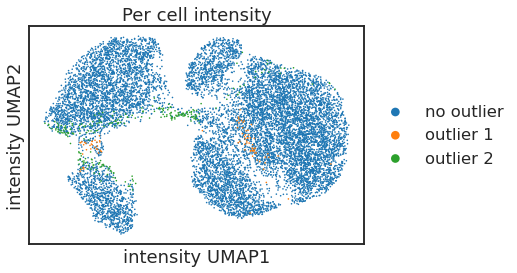

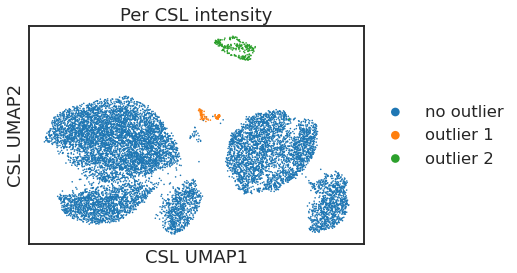

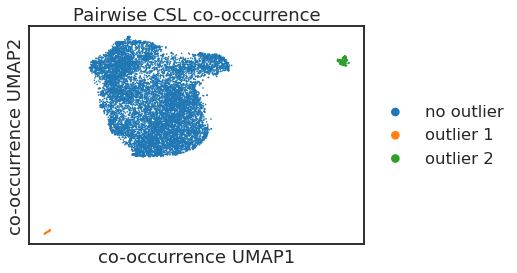

In [9]:
sns.set_style('white')
sns.set_context('talk')

catplot('mpp_umap', 'outlier_groups', 'intensity UMAP', save='suppl_outliers_intensity_umap.png', title='Per cell intensity')
catplot('intensity_umap', 'outlier_groups', 'CSL UMAP', save='suppl_outliers_cluster_intensity_umap.png', title='Per CSL intensity')
catplot('co_occurrence_umap', 'outlier_groups', 'co-occurrence UMAP', save='suppl_outliers_co_occ_umap.png', title='Pairwise CSL co-occurrence')

## Analyse outliers

In [10]:
for well_name, g in outliers.obs.groupby('well_name'):
    print(well_name)
    print(g)

I09
      mapobject_id plate_name well_name  well_pos_y  well_pos_x  tpoint  \
11-0        199656    plate01       I09           5           2       0   
20-0        200755    plate01       I09           4           3       0   
74-0        228084    plate01       I09           0           1       0   
290-0       291064    plate01       I09           0           3       0   
318-0       324160    plate01       I09           0           2       0   
451-0       359383    plate01       I09           3           1       0   
457-0       359393    plate01       I09           3           1       0   
463-0       359399    plate01       I09           3           1       0   

       zplane  label  is_border  mapobject_id_cell  ... perturbation  \
11-0        0     32          0             199610  ...       normal   
20-0        0     13          0             200701  ...       normal   
74-0        0     17          0             228063  ...       normal   
290-0       0     35          0 

INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['y', 'obj_ids', 'x', 'mpp'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7218204 mpps with shape (1, 1, 34) from 557 objects). Data keys: ['y', 'obj_ids', 'x', 'clustering_res0.5', 'mpp'].
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['y', 'obj_ids', 'x', 'mpp', 'clustering_res0.5']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09
INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 8 objects
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (14097457 mpps with shape (1, 1, 35) from 1025 objects). Data keys: ['y', 'obj_ids', 'x', 'mpp'].
INFO:MPPData:Loaded data 

ValueError: Number of rows must be a positive integer, not 0

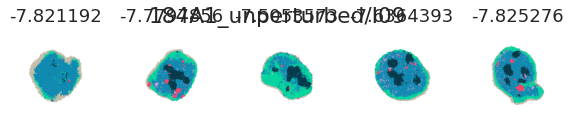

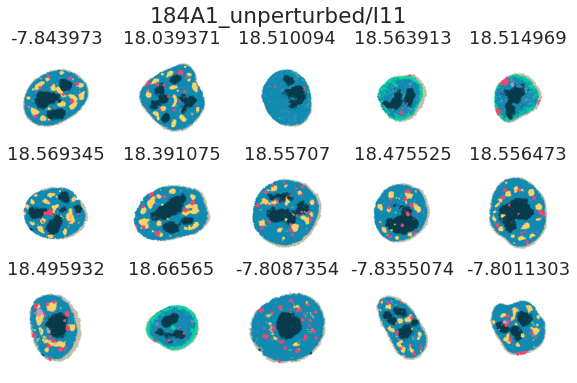

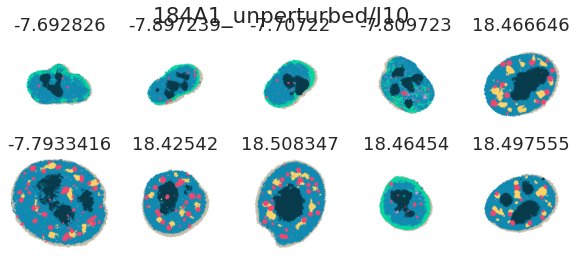

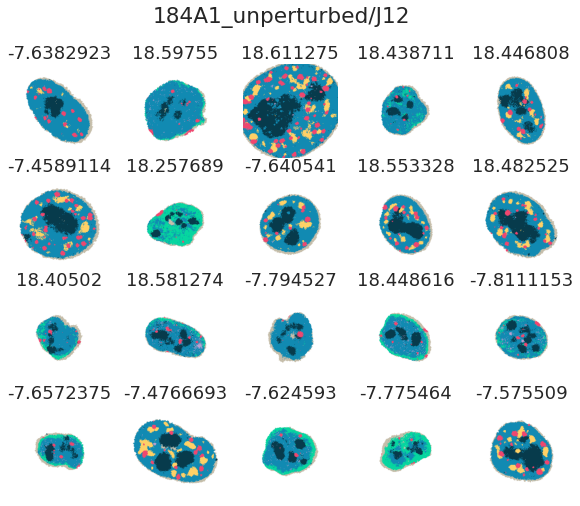

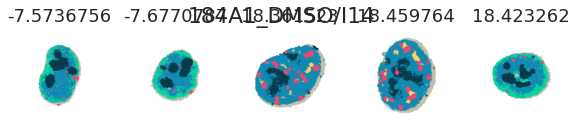

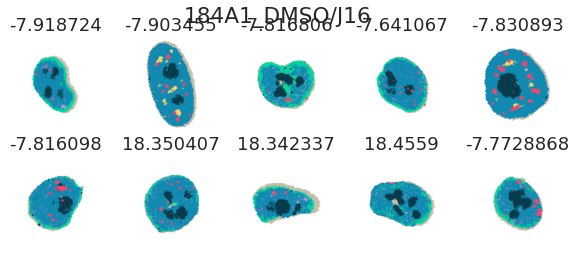

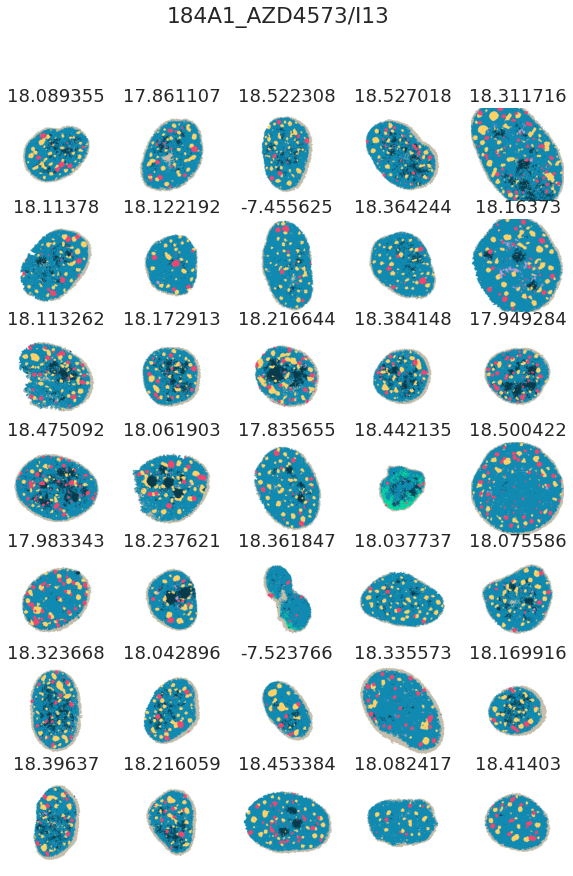

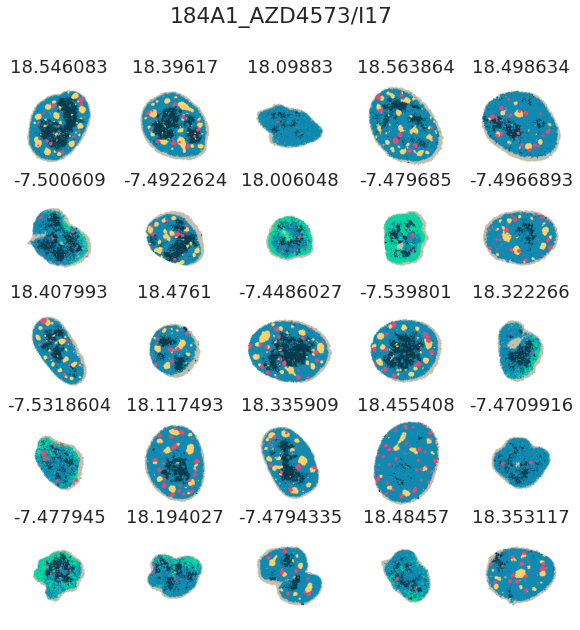

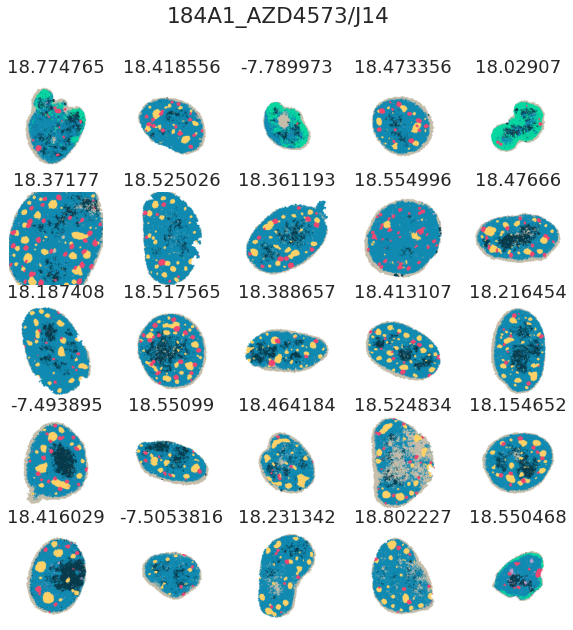

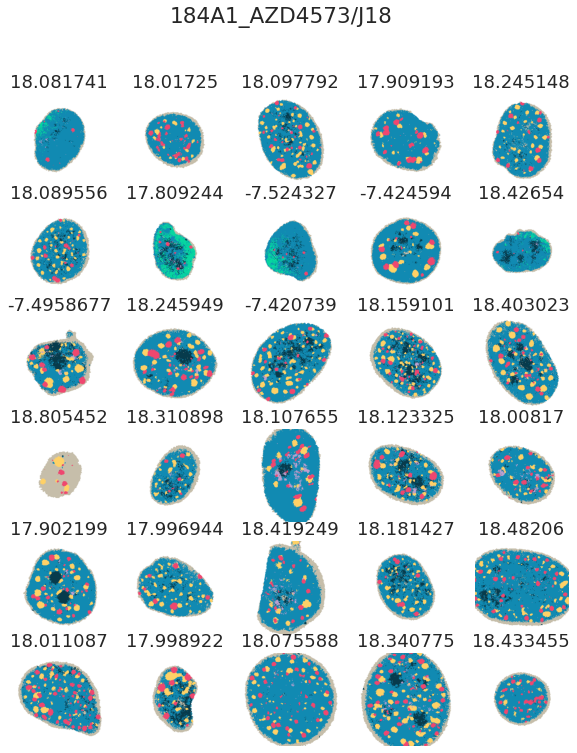

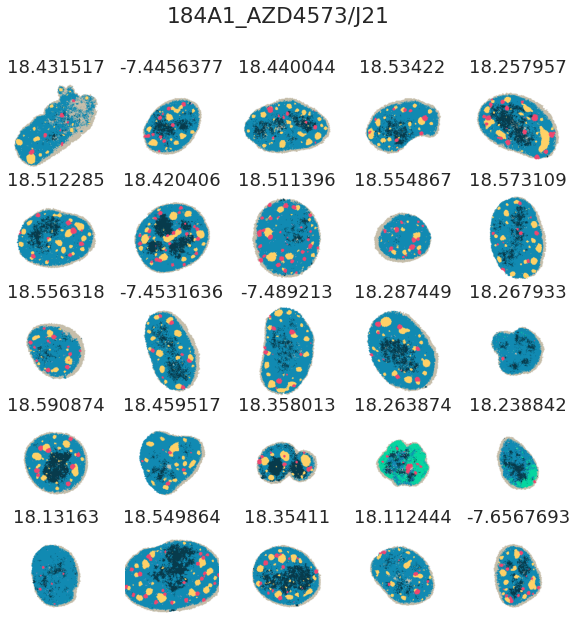

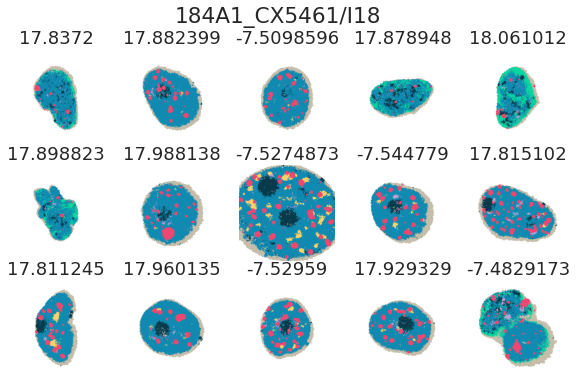

<Figure size 720x0 with 0 Axes>

In [12]:
# load and plot outlier cells per well

for data_dir in data_dirs:
    res = outliers.obs[outliers.obs['well_name'] == data_dir.split('/')[-1]]

    if len(res) > 0:
        mpp_data = MPPData.from_data_dir(data_dir, base_dir=os.path.join(campa_config.EXPERIMENT_DIR, 'VAE_all/CondVAE_pert-CC/aggregated/full_data'), 
                                                        keys=['x', 'y', 'obj_ids', 'clustering_res0.5'], optional_keys=[], data_config='NascentRNA')
        mpp_data.subset(obj_ids=[int(obj_id) for obj_id in list(res['mapobject_id'])])
        # convert clustering to str for correct color mapping (for this experiment are saved as int, but need to be converted to str)
        mpp_data._data['clustering_res0.5'] = mpp_data.data('clustering_res0.5').astype('<U21')
        imgs = mpp_data.get_object_imgs(data='clustering_res0.5', annotation_kwargs={'color':True, 'annotation': annotation, 'to_col': 'annotation'}, img_size=200)
        
        fig, axes = plt.subplots(len(imgs)//5, 5, figsize=(10, (len(imgs)//5)*2))
        for i,(img, ax) in enumerate(zip(imgs, axes.flat)):
            ax.imshow(img)
            obj_id = res['mapobject_id'][i]
            xcoord = outliers[outliers.obs['mapobject_id']==obj_id].obsm['X_co_occurrence_umap'][0,0]
            ax.set_title(xcoord)
        for ax in axes.flat:
            ax.axis('off')
        fig.suptitle(data_dir)


### Boxplots of differences between outlier groups and main cells

In [13]:
# get features again, this time aggregated
# aggregate object statistics, using additional thresholding
for extr in extrs.values():
    _ = extr.get_object_stats(area_threshold=10, agg=['median'])
# combined adatas for plotting
features = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')
features.obsm['object_stats_agg'].columns = pd.MultiIndex.from_tuples([tuple(i.split("|")) for i in features.obsm['object_stats_agg'].columns])

adata_outliers = features[features.obs['mapobject_id'].isin(outliers.obs['mapobject_id'])]
assert (outliers.obs['mapobject_id'] == adata_outliers.obs['mapobject_id']).all()
adata_outliers.obsm['X_co_occurrence_umap'] = outliers.obsm['X_co_occurrence_umap']

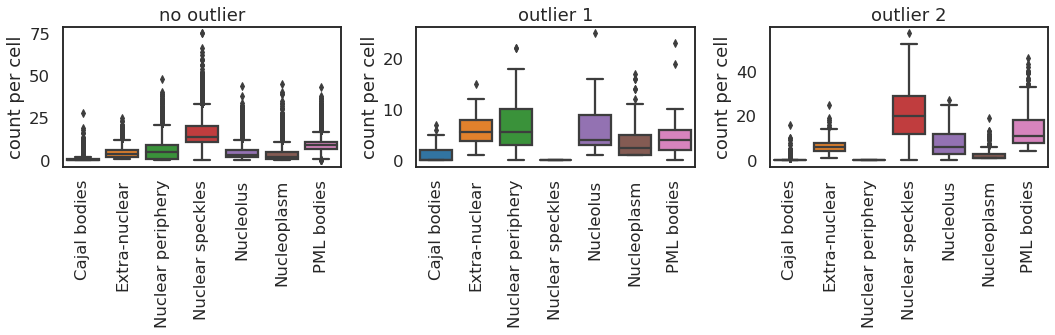

In [14]:
fig, axes = plt.subplots(1,3, squeeze=False, figsize=(15,5))

ax = axes[0,0]
g = sns.boxplot(data=features[~adata.obs['co_occurrence_umap_outlier']].obsm['object_stats_agg']['count'], ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
ax.set_ylabel('count per cell')
ax.set_title('no outlier')

ax = axes[0,1]
g = sns.boxplot(data=adata_outliers[group1].obsm['object_stats_agg']['count'], ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
ax.set_ylabel('count per cell')
ax.set_title('outlier 1')

ax = axes[0,2]
g = sns.boxplot(data=adata_outliers[group2].obsm['object_stats_agg']['count'], ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
ax.set_ylabel('count per cell')
ax.set_title('outlier 2')

plt.tight_layout()
plt.savefig(fig_dir/"suppl_outliers_barplot_count.png", dpi=300)

# group 2 has no nuclear speckles
# group 3 had no nuclear periphery


# OLD
Before, had three groups, with group1 not having co-occ scores calulated.
This code investigates these cells and comes to the conclusion, that co-occ scores should be recalculated for these cells (probably a bug in early co-occ code)

After recalculation of co-occ scores, this group has disappeared
### Plot cells from group1

In [7]:
# load mpp_datas
mpp_datas = {}
for data_dir in data_dirs:
    mpp_datas[data_dir] = MPPData.from_data_dir(data_dir, base_dir=os.path.join(campa_config.EXPERIMENT_DIR, 'VAE_all/CondVAE_pert-CC/aggregated/full_data'), 
                                                        keys=['x', 'y', 'obj_ids', 'clustering_res0.5'], optional_keys=[], data_config='NascentRNA')

INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7218204 mpps with shape (1, 1, 34) from 557 objects). Data keys: ['clustering_res0.5', 'y', 'x', 'obj_ids', 'mpp'].
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['y', 'x', 'obj_ids', 'mpp', 'clustering_res0.5']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (14097457 mpps with shape (1, 1, 35) from 1025 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I11.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:

INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 1 objects
INFO:MPPData:Created new: MPPData for NascentRNA (25931 mpps with shape (1, 1, 35) from 1 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'clustering_res0.5'].
INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 1 objects
INFO:MPPData:Created new: MPPData for NascentRNA (24100 mpps with shape (1, 1, 35) from 1 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'clustering_res0.5'].
INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 1 objects
INFO:MPPData:Created new: MPPData for NascentRNA (27780 mpps with shape (1, 1, 35) from 1 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'clustering_res0.5'].
INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 1 objects
INFO:MPPData:Created new: MPPData for NascentRNA (27090 mpps with shape (1, 1, 35) from 1 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'clustering_res0.5'].
INFO:MPPData:Before subsetti

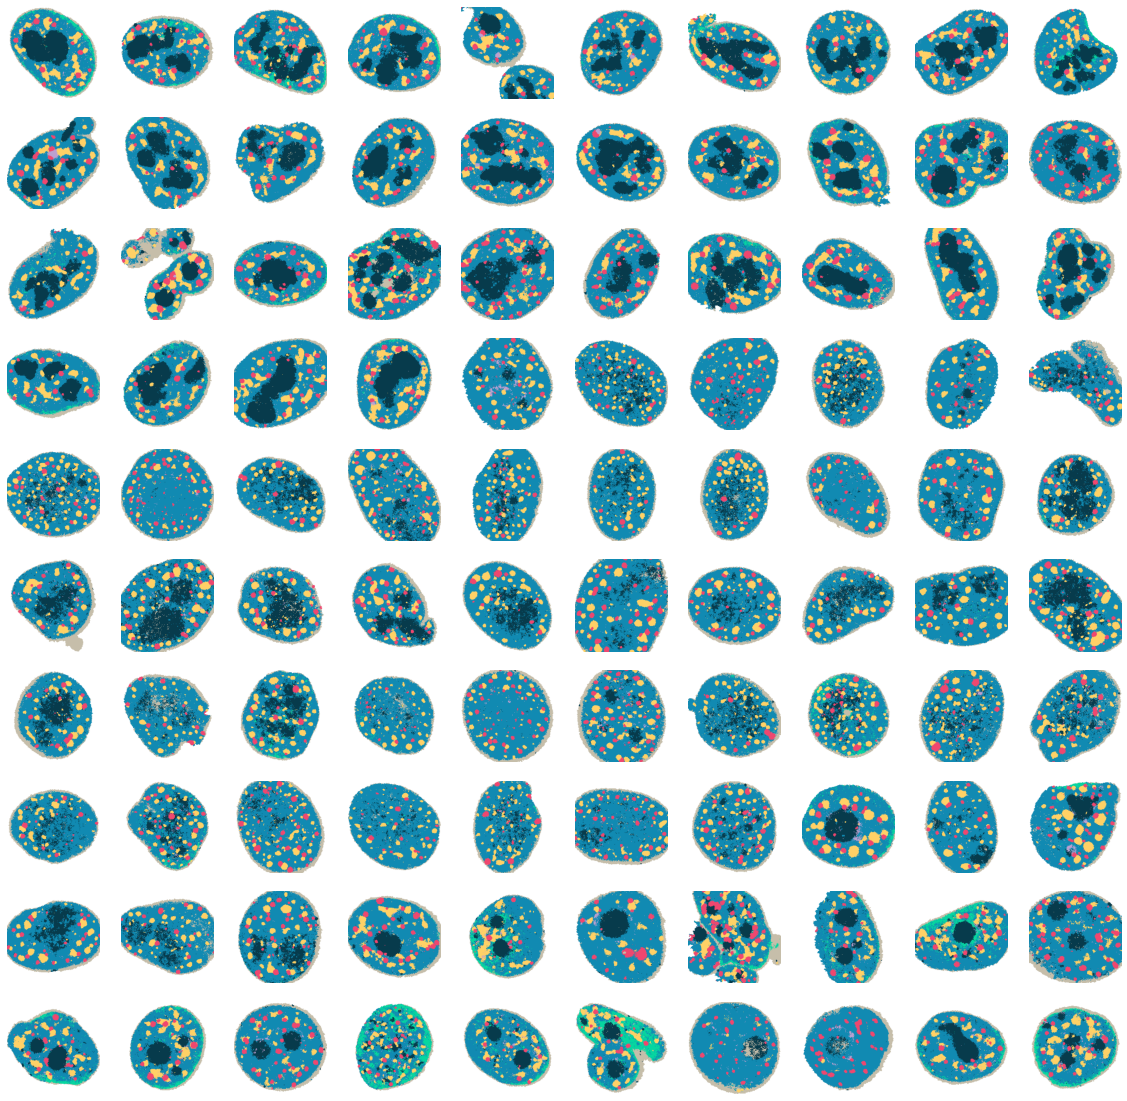

In [16]:
def plot_cell(obj_id, adata, mpp_datas, ax=None):
    well_name = adata[adata.obs['mapobject_id'] == obj_id].obs['well_name'][0]
    for data_dir in data_dirs:
        if data_dir.split('/')[-1] == well_name:
            break 
    mpp_data = mpp_datas[data_dir]
    mpp_data = mpp_data.subset(obj_ids=[int(obj_id)], copy=True)
    # convert clustering to str for correct color mapping (for this experiment are saved as int, but need to be converted to str)
    mpp_data._data['clustering_res0.5'] = mpp_data.data('clustering_res0.5').astype('<U21')
    imgs = mpp_data.get_object_imgs(data='clustering_res0.5', annotation_kwargs={'color':True, 'annotation': annotation, 'to_col': 'annotation'}, img_size=200)

    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.imshow(imgs[0])
    ax.axis('off')
    return ax


fig, axes = plt.subplots(10,10, figsize=(20,20))
for i, ax in enumerate(axes.flatten()):
    plot_cell(adata_outliers[group1].obs['mapobject_id'][i], adata_outliers, mpp_datas, ax=ax)


### recalculate co-occ for one example

-> for group 1 there was an issue with the co_occ scores (bug in squidpy code) 
-> will recalculate and fix

In [5]:
import campa.tl._features

In [48]:
obj_id = int(adata_outliers.obs['mapobject_id'][0])
interval = extrs[data_dirs[0]].adata.uns['co_occurrence_params']['interval']
self = extrs[data_dirs[0]]

In [50]:
cluster_names = {n: i for i, n in enumerate(self.clusters + [""])}
coords2_list = campa.tl._features._prepare_co_occ(interval)

# recalculate co_occ for one example
mpp_data = self.mpp_data.subset(obj_ids=[obj_id], copy=True)
img, (pad_x, pad_y) = mpp_data.get_object_img(
    obj_id,
    data=str(self.params["cluster_name"]),
    annotation_kwargs={
        "annotation": self.annotation,
        "to_col": self.params["cluster_col"],
    },
)
# convert labels to numbers
img = np.vectorize(cluster_names.__getitem__)(img)
clusters1 = np.vectorize(cluster_names.__getitem__)(
    campa.tl._features.annotate_clustering(
        mpp_data._data[str(self.params["cluster_name"])],
        self.annotation,
        str(self.params["cluster_name"]),
        self.params["cluster_col"],
    )
)
# shift coords according to image padding, st coords correspond to img coords
coords1 = (np.array([mpp_data.x, mpp_data.y]) - np.array([pad_x, pad_y])[:, np.newaxis]).astype(
    np.int64
)
self.log.info(f"co-occurrence for {obj_id}, with {len(mpp_data.x)} elements")
co_occ = campa.tl._features._co_occ_opt(
    coords1,
    coords2_list,
    clusters1,
    img,
    num_clusters=len(self.clusters),
    num_processes=None,
)

INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 1 objects
INFO:MPPData:Created new: MPPData for NascentRNA (9244 mpps with shape (1, 1, 34) from 1 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'labels', 'clustering_res0.5', 'latent', 'conditions'].
INFO:FeatureExtractor:co-occurrence for 199656, with 9244 elements
/Users/hannah.spitzer/projects/pelkmans/software_new/campa/campa/tl/_features.py:1062: RuntimeWarning: invalid value encountered in true_divide
  probs_con[c, :] = probs_conditional / probs


In [56]:
self.adata[self.adata.obs['mapobject_id']==str(obj_id)].obsm['co_occurrence_Cajal bodies_Cajal bodies']

0         1         2         3         4         5         6  \
11  3.596743  3.046909  2.829715  2.419256  2.072473  1.764906  1.529869   

           7         8         9        10        11        12        13  \
11  1.373342  1.274561  1.108869  1.114577  1.091727  0.981442  0.915825   

          14        15        16        17        18  
11  0.999707  0.987697  0.964766  0.985577  0.947198

In [51]:
co_occ

array([[[ 3.596743  ,  3.046909  ,  2.8297148 ,  2.4192562 ,
          2.0724728 ,  1.7649063 ,  1.5298688 ,  1.3733416 ,
          1.2745606 ,  1.1088694 ,  1.1145767 ,  1.091727  ,
          0.98144245,  0.9158253 ,  0.99970704,  0.98769665,
          0.96476614,  0.9855765 ,  0.9472428 ],
        [ 0.1219338 ,  0.12680124,  0.20146042,  0.28918082,
          0.37363636,  0.52859783,  0.6821195 ,  0.8450254 ,
          1.0594008 ,  1.2245934 ,  1.2585806 ,  1.2382859 ,
          1.1890965 ,  1.1766852 ,  1.078728  ,  0.9941453 ,
          0.90733963,  0.9074508 ,  0.8401868 ],
        [ 0.71073633,  0.7114305 ,  0.7395536 ,  0.7774676 ,
          0.8385252 ,  0.8533052 ,  0.8830591 ,  0.89712346,
          0.92026204,  0.93215346,  0.8884455 ,  0.8729931 ,
          0.85951847,  0.87243116,  0.86415756,  0.8566941 ,
          0.8876642 ,  0.959376  ,  1.1134456 ],
        [        nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,